# Research Question 2:

We use **Causal Inference** to determine any causal effect of PM2.5 concentration on COPD (chronic obstructive pulmonary disease).

*resources:*

* https://towardsdatascience.com/causal-inference-with-continuous-treatments-5ff691869a65
* difference in outcomes - lab 8
* https://www.practicalpropensityscore.com/continuous.html

In [2]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [ ]:
# read CDI data as DataFrame
cdi = pd.read_csv('data/cdi.csv')

## Preparing COPD and smoking datasets

In [ ]:
copd = cdi[(cdi['Topic'] == "Chronic Obstructive Pulmonary Disease") &
           (cdi['Question'] == 'Prevalence of chronic obstructive pulmonary disease among adults >= 18') &
           (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]

copd = copd[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "COPD Prevalence"})

In [ ]:
smoking = cdi[(cdi["Topic"] == 'Tobacco') & (cdi["Question"] == "Current smoking among adults aged >= 18 years") &
              (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]

smoking = smoking[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "Smoking Prevalence"})

In [ ]:
yearly_pm25_avg = pd.read_csv("data/yearly_pm_by_state.csv")
yearly_pm25_avg = yearly_pm25_avg.melt(id_vars='abbrev').rename(columns={'variable': 'YEAR', 'value': 'pm25'})
yearly_pm25_avg.head()

,abbrev,YEAR,pm25
0,AL,2011,11.748242
1,AZ,2011,7.838444
2,AR,2011,11.059018
3,CA,2011,9.746000
4,CO,2011,5.870499


In [ ]:
copd["YearStart"] = copd["YearStart"].astype(str)
smoking["YearStart"] = smoking["YearStart"].astype(str)
yearly_pm25_avg["YEAR"] = yearly_pm25_avg["YEAR"].astype(str)

## Merging CDI and PM2.5 datasets

In [ ]:
data = yearly_pm25_avg.merge(smoking, left_on=["YEAR", "abbrev"], right_on=['YearStart', 'LocationAbbr'], how='inner')
data = data[["YEAR", "abbrev", "pm25", "Smoking Prevalence"]]

In [ ]:
df = copd.merge(data, left_on=["LocationAbbr", "YearStart"], right_on=["abbrev", "YEAR"], how='inner')
df.head()

,YearStart,LocationAbbr,LocationDesc,COPD Prevalence,LowConfidenceLimit,HighConfidenceLimit,YEAR,abbrev,pm25,Smoking Prevalence
0,2011,AL,Alabama,9.3,8.4,10.2,2011,AL,11.748242,24.6
1,2013,AL,Alabama,9.9,8.9,11.0,2013,AL,9.714757,22.1
2,2012,AL,Alabama,9.3,8.5,10.2,2012,AL,11.454434,24.4
3,2014,AL,Alabama,9.7,8.9,10.5,2014,AL,12.506239,21.7
4,2012,AR,Arkansas,8.2,7.4,9.2,2012,AR,9.843660,25.7


In [ ]:
data_filtered = df[["YEAR", "abbrev", "pm25", "Smoking Prevalence", "COPD Prevalence"]]
data_filtered = data_filtered.rename(columns={'Smoking Prevalence':"smoking_prevalence", "COPD Prevalence": "copd_prevalence"})
data_filtered.sort_values(by='pm25').head()

,YEAR,abbrev,pm25,smoking_prevalence,copd_prevalence
195,2014,WY,4.797520,19.9,6.4
97,2013,MT,4.929152,19.6,5.9
193,2013,WY,5.199149,20.8,6.7
104,2014,ND,5.200405,20.6,4.4
182,2012,WA,5.418286,17.2,5.5


## Outcome regression with IPW

In [ ]:
def conditional_densities(data, use_confounders=True):
    formula = "pm25 ~ 1"
    if use_confounders:
        formula += "+ smoking_prevalence"
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm(
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )
    densities = density.pdf(data["pm25"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities

In [ ]:
denominator = conditional_densities(data_filtered, use_confounders=True)
numerator = conditional_densities(data_filtered, use_confounders=False)
generalized_ipw = numerator / denominator

In [ ]:
generalized_ipw

0      0.729269
1      0.954873
2      0.764066
3      0.893179
4      0.953540
         ...   
191    0.916872
192    1.652012
193    1.242220
194    1.423198
195    1.110807
Length: 196, dtype: float64

In [ ]:
model_copd = sm.formula.wls(
    "copd_prevalence ~ 1 + pm25 ",
    data=data_filtered,
    weights=generalized_ipw,
).fit()

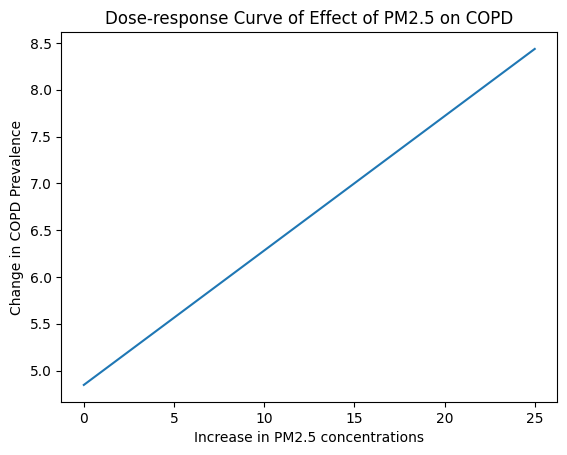

In [ ]:
concentration = list(range(26))
concentration = pd.DataFrame(
    data={"pm25": concentration},
    index=concentration)
response = model_copd.predict(concentration)
ax = response.plot(
    kind="line",
    xlabel="Increase in PM2.5 concentrations",
    ylabel="Change in COPD Prevalence",
    title="Dose-response Curve of Effect of PM2.5 on COPD"
)

In [ ]:
model_copd.conf_int()

,0,1
Intercept,3.827262,5.865089
pm25,0.037483,0.249698


In [ ]:
model_copd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        copd_prevalence   R-squared:                       0.035
Model:                            WLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     7.123
Date:                Mon, 08 May 2023   Prob (F-statistic):            0.00825
Time:                        21:08:26   Log-Likelihood:                -356.43
No. Observations:                 196   AIC:                             716.9
Df Residuals:                     194   BIC:                             723.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8462      0.517      9.381      0.000       3.827       5.865
pm25           0.1436      0.054      2.669      0.008       0.037       0.250
==============================================================================
Omnibus:                       29.642   Durbin-Watson:                   1.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.991
Skew:                           0.890   Prob(JB):                     7.62e-10
Kurtosis:                       4.406   Cond. No.                         47.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""